# Etude de cas data BCG ClientCo, Groupe 9

# Churn prediction use case

This Notebook contains the whole code we use to develop the churn prediction model. The Notebook is structured as following:
- **First section**: Feature extraction (including data cleaning)
- **Second section**: Model testing
- **Third section**: Evaluation metrics of the selected model

## Imports 

In [10]:
import math
import sklearn
import numpy as np
import pandas as pd
import datetime
from scipy import stats
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from functools import reduce
from matplotlib import pyplot as plt
from time import time
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
import graphviz 
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings("ignore")

# First Section :Feature Extraction

In [2]:
# Some useful functions

def last_list(x):
    return(x.iloc[-1])
def last_avg(x):
    return(x[-3:].mean())
def quantile60(x):
    return (x.quantile(q=0.6))
def quantile70(x):
    return (x.quantile(q=0.7))
def quantile75(x):
    return (x.quantile(q=0.75))
def quantile80(x):
    return (x.quantile(q=0.8))
def quantile85(x):
    return (x.quantile(q=0.85))
def quantile90(x):
    return (x.quantile(q=0.9))

def get_previous(x,y):
    if x == y:
        return (np.datetime64('NaT') )
    else:
        return(x)

def regression(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return(slope,r_value**2)


**This section is not supposed to be run, it's the data extraction step. The extracted dataset is already saved and attached**

In [ ]:
# Define paths
path_input = 
path_output = 



# Open transctions data file

df2 = pd.read_csv(path_input,sep=';')

print("end read_csv")

# Seperate the data

df1 = df2.loc[df2.date_order < "2019-04-01"] # data used to build the dataset
df2 = df2.loc[df2.date_order >= "2019-04-01"] # data used to label the dataset - Is the client a churner?

print("enter for loop")



# Build each transaction

for (df,temps) in zip([df1,df2],['pre_04_2019','post_04_2019']):
    df.sort_values(by=['date_order'],inplace=True)
    df['date_order_dt'] = pd.to_datetime(df['date_order'],format = '%Y-%m-%d',errors='coerce')
    df['date_invoice_dt'] = pd.to_datetime(df['date_invoice'],format = '%Y-%m-%d',errors='coerce')
    print('first groupby started')
    orders_df = df.groupby(['client_id','date_order_dt','order_channel',
                        'date_invoice_dt']).sum()[['sales_net']]
    print('first groupby ended')

orders_df = orders_df.add_suffix('').reset_index()
orders_df.set_index('client_id',inplace=True)


# Extract all the features (we wanted to test) for each client

orders_df['previous_order'] = orders_df.groupby(by=['client_id'])['date_order_dt'].shift()
orders_df['delay'] = orders_df['date_invoice_dt'] - orders_df['date_order_dt']
orders_df['delay'] = orders_df['delay'].apply(lambda x : x.days)

orders_df['delta_days'] = (orders_df.date_order_dt - orders_df.previous_order)
orders_df['delta_days'] = orders_df['delta_days'].apply(lambda x : x.days)

dic_regr = {}
dic_regr['client_id'] = []
dic_regr['slope_delta_time'] = []
dic_regr['r2_delta_time'] = []
dic_regr['slope_sales'] = []
dic_regr['r2_sales'] = []

for client_id in tqdm(orders_df.index.unique()):

    test_df = orders_df.loc[orders_df.index == client_id][['date_order_dt','sales_net','delta_days']]
    x = (test_df.date_order_dt -  test_df.date_order_dt.iloc[0])
    x = [i.days for i in x]
    y1 = test_df.sales_net.fillna(0)
    y2 = test_df.delta_days.fillna(0)
    dic_regr['client_id'].append(client_id)
    dic_regr['slope_delta_time'].append(regression(x,y1)[0])
    dic_regr['r2_delta_time'].append(regression(x,y1)[1])
    dic_regr['slope_sales'].append(regression(x,y2)[0])
    dic_regr['r2_sales'].append(regression(x,y2)[1])

regr_df = pd.DataFrame(dic_regr)
regr_df.set_index('client_id',inplace=True)

# Create date variable that records recency
snapshot_date = max(orders_df.date_order_dt) + dt.timedelta(days=1)

# Aggregate data by each customer
print('second groupby started')
customers = orders_df.groupby(['client_id']).agg(
  Recency = ("date_order_dt", lambda x: (snapshot_date - x.max()).days),
  Frequency = ("sales_net", 'count'),
  AOV = ("sales_net", 'mean'),
  total_revenue = ("sales_net", 'sum'),                                            
  max_order = ("sales_net", 'max'),
  last_purchase = ('sales_net',last_list),
  avg_delta_time = ('delta_days','mean'),
  max_delta_time = ('delta_days','max'),
  std_delta_time = ('delta_days','std'),
  median_delta_time = ('delta_days','median'),
  q6 = ('delta_days',quantile60),
  q7 = ('delta_days',quantile70),
  q75 = ('delta_days',quantile75),
  q8 = ('delta_days',quantile80),
  q85 = ('delta_days',quantile85),
  q9 = ('delta_days',quantile90),
  last_delta_time = ('delta_days',last_list),
  avg_last_3_delta = ('delta_days',last_avg),
  last_channel = ('order_channel',last_list),
  avg_last_3_delays = ('delay', last_avg))

print('second groupby ended')

customers = pd.merge(customers,regr_df,how='left',right_index=True,left_index=True)


customers.to_csv(path_output)

### Creation of a complete DataSet

In [11]:
pd.set_option('display.max_rows', 50)
data_set = pd.read_csv('./input_data/customers_pre_2019.csv')
data_post = pd.read_csv('./input_data/customers_post_2019.csv')

# defining Labels : if Client bought in 2019 then he is labeled 0 (not churn) otherwise he is labeled 1 (churn)
clients_y = data_post.client_id.unique()
L = [(x in clients_y) for x in data_set.client_id.unique()]
data_set['churn'] = [abs(x*1-1) for x in L]

data_set['slope_delta_time'] = data_set['slope_delta_time']*data_set['r2_delta_time']
data_set['slope_sales'] = data_set['slope_sales']*data_set['r2_sales']

data_set.drop(['r2_sales','r2_delta_time','last_channel'],axis=1,inplace=True)

data_set.set_index('client_id',inplace=True)

X = data_set
X = X.loc[(X.Frequency > 6) ] # we keep only customers with enough data
X.dropna(inplace=True)

df_X = pd.DataFrame(X)

y = df_X['churn'] 
data_X = df_X.drop(['churn'],axis=1)

### Correlations

In [12]:
# Correlation as an indication for feature relevance
df_corr = df_X.corr()[['churn']]
df_corr['abs_churn'] = abs(df_corr.churn)
df_corr = df_corr.sort_values(by=['abs_churn'],ascending=False)[['churn']]
df_corr

,churn
churn,1.000000
Recency,0.571969
slope_sales,0.178475
Frequency,-0.120042
avg_last_3_delta,0.113205
std_delta_time,0.096092
last_delta_time,0.094157
total_revenue,-0.071348
q9,0.068340
avg_delta_time,0.066001


In [13]:
# We select the features
columns = ['Frequency','AOV','total_revenue','max_order','last_purchase','std_delta_time',
          'q9','slope_sales','slope_delta_time']
data_X = data_X[columns]


In [14]:
data_X.head(3)

,Frequency,AOV,total_revenue,max_order,last_purchase,std_delta_time,q9,slope_sales,slope_delta_time
client_id,,,,,,,,,
6,7,451.477729,3.160344e+03,1358.089878,98.8770,76.735042,157.5,5.096656e-03,-0.721056
14,1358,1452.360862,1.972306e+06,40529.598120,113.5740,0.763622,1.0,3.209852e-08,0.001581
18,306,454.009317,1.389269e+05,11578.098800,372.4068,2.371881,4.0,4.345515e-10,0.006866


# Second section: Model testing

### To see testing of the other models, please look at the secondary notebook

**Here You can find the selected Classifier ( Random Forest ) Among others (Logistic regression, Decision tree, Ada Boost, Bayes, Gradient Boosting)**

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1)) # min max scaler
scoring = 'recall'
X = data_X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Undersampling of Train Set (Because highly umbalanced labels)

In [17]:
df_train = pd.concat([X_train, y_train],axis=1)

# Class count
count_class_0, count_class_1 = df_train.churn.value_counts()

# Divide by class
df_class_0 = df_train[df_train['churn'] == 0]
df_class_1 = df_train[df_train['churn'] == 1]

repartition_rate = 1 # 
df_class_0_under = df_class_0.sample(count_class_1*repartition_rate)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.churn.value_counts())


Random under-sampling:
1    7991
0    7991
Name: churn, dtype: int64


In [18]:
df_test_under = df_test_under.sample(frac=1) # Schuffle DataFrame

In [19]:
X_train = df_test_under[columns]
y_train = df_test_under.churn

## Random Forest

In [20]:
pipeline =  Pipeline([('scaler', scaler),
                      
                      ('random_forest', RandomForestClassifier())])
param_grid = {'random_forest__max_depth': np.arange(5, 16, 5),
              'random_forest__n_estimators': np.arange(70, 201, 40)}

print("Entrée dans la CV")
kfold = StratifiedKFold(n_splits=3)
clf = GridSearchCV(pipeline, param_grid, cv=kfold, scoring=scoring)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Résultats de la validation croisée :")
for mean, std, params in tqdm(zip(clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score'], clf.cv_results_['params'])):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(scoring, mean, std*2, params))

print("\nBest params : {}".format(clf.best_params_)) 
print("Prediction recall = {:.3f}".format(recall_score(y_test, y_pred))) 
print("Prediction accuracy = {:.3f}".format(accuracy_score(y_test, y_pred)))

Entrée dans la CV
Résultats de la validation croisée :


recall = 0.742 (+/-0.026) for {'random_forest__max_depth': 5, 'random_forest__n_estimators': 70}
recall = 0.744 (+/-0.018) for {'random_forest__max_depth': 5, 'random_forest__n_estimators': 110}
recall = 0.745 (+/-0.024) for {'random_forest__max_depth': 5, 'random_forest__n_estimators': 150}
recall = 0.740 (+/-0.020) for {'random_forest__max_depth': 5, 'random_forest__n_estimators': 190}
recall = 0.751 (+/-0.019) for {'random_forest__max_depth': 10, 'random_forest__n_estimators': 70}
recall = 0.755 (+/-0.015) for {'random_forest__max_depth': 10, 'random_forest__n_estimators': 110}
recall = 0.755 (+/-0.013) for {'random_forest__max_depth': 10, 'random_forest__n_estimators': 150}
recall = 0.755 (+/-0.015) for {'random_forest__max_depth': 10, 'random_forest__n_estimators': 190}
recall = 0.762 (+/-0.011) for {'random_forest__max_depth': 15, 'random_forest__n_estimators': 70}
recall = 0.762 (+/-0.011) for {'random_forest__max_depth': 15, 'random_forest__n_estimators': 110}
recall = 0.765 (+

[[15337  5825]
 [  664  2075]]


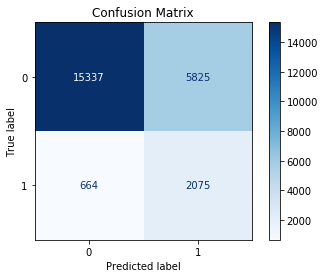

In [21]:
clf = RandomForestClassifier(max_depth = 15, n_estimators = 190)
clf.fit(X_train, y_train)
title = 'Confusion Matrix'
disp = plot_confusion_matrix(clf, X_test, y_test,
                             cmap=plt.cm.Blues)
disp.ax_.set_title(title)

print(disp.confusion_matrix)

[[0.72469521 0.27530479]
 [0.24205915 0.75794085]]


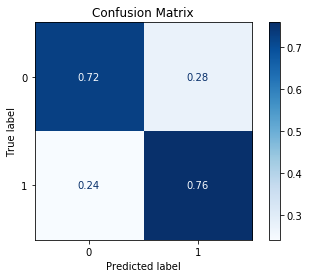

In [22]:
clf = RandomForestClassifier(max_depth = 15, n_estimators = 190)
clf.fit(X_train, y_train)
title = 'Confusion Matrix'
disp = plot_confusion_matrix(clf, X_test, y_test,
                             cmap=plt.cm.Blues, normalize = 'true')
disp.ax_.set_title(title)

print(disp.confusion_matrix)

# Feature Importances

Based on the recall and accuracy (hence taking account of precision) of different models with different hyperparameters we decided to keep the **RandomForest Classifier with (max_depth = 15 and n_estimators = 190)**

In [23]:
from sklearn.feature_selection import SelectFromModel


sel = SelectFromModel(RandomForestClassifier(n_estimators = 190,max_depth = 15),threshold = 0)
sel.fit(X_train, y_train)

selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

d_features = {}
for k,v in zip(X.columns,sel.estimator_.feature_importances_):
    d_features[k] = v

d_features = {k: v for k, v in sorted(d_features.items(), key=lambda item: item[1],reverse=True)}
sorted_features = list(d_features.keys())

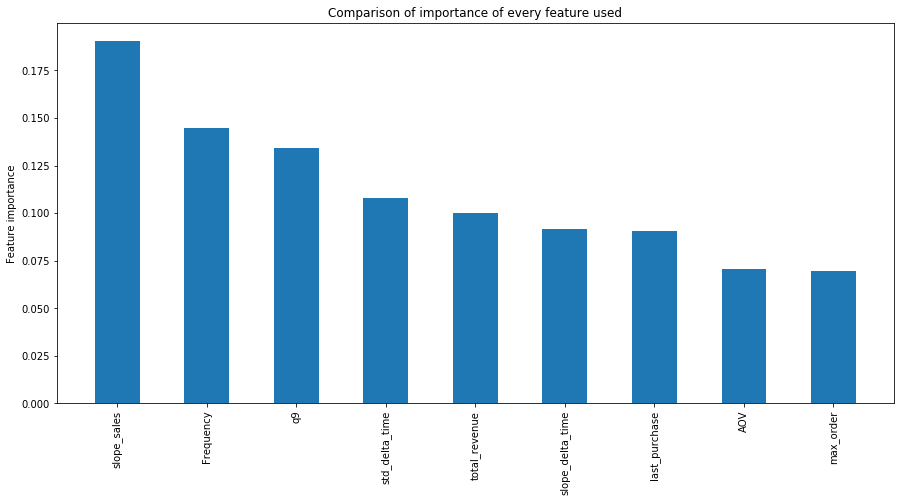

In [24]:

fig, ax = plt.subplots(figsize=(15,7))
rects1 = ax.bar(d_features.keys(), d_features.values(), 0.5)
ax.set_ylabel('Feature importance')
ax.set_title("Comparison of importance of every feature used")
ax.set_xticks(X.columns)
plt.xticks(rotation='vertical')
plt.show()


### Optimization of the number of features used

We will look at how the performances change depending on the number of features selected

In [25]:
list_columns = []
list_recall = []
list_accuracy = []
for col in sorted_features:
    list_columns.append(col)
    X_train_local = X_train[list_columns].copy()
    X_test_local = X_test[list_columns].copy()
    pipeline =  Pipeline([('scaler', scaler),

                          ('random_forest', RandomForestClassifier())])
    param_grid = {'random_forest__max_depth': [15],
                  'random_forest__n_estimators': [190]}

    print("Entrée dans la CV")
    kfold = StratifiedKFold(n_splits=3)
    clf = GridSearchCV(pipeline, param_grid, cv=kfold, scoring=scoring)
    clf.fit(X_train_local, y_train)

    y_pred = clf.predict(X_test_local)
    print("Résultats de la validation croisée :")
    for mean, std, params in (zip(clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score'], clf.cv_results_['params'])):
        print("{} = {:.3f} (+/-{:.03f}) for {}".format(scoring, mean, std*2, params))

    print("Prediction recall = {:.3f}".format(recall_score(y_test, y_pred)))
    print("Accuracy :",accuracy_score(y_test, y_pred))
    list_recall.append(recall_score(y_test, y_pred))
    list_accuracy.append(accuracy_score(y_test, y_pred))
    print('Features used:', list_columns)
    print('')

Entrée dans la CV
Résultats de la validation croisée :
recall = 0.637 (+/-0.018) for {'random_forest__max_depth': 15, 'random_forest__n_estimators': 190}
Prediction recall = 0.626
Accuracy : 0.6380486172126689
Features used: ['slope_sales']

Entrée dans la CV
Résultats de la validation croisée :
recall = 0.620 (+/-0.025) for {'random_forest__max_depth': 15, 'random_forest__n_estimators': 190}
Prediction recall = 0.629
Accuracy : 0.6466675034517384
Features used: ['slope_sales', 'Frequency']

Entrée dans la CV
Résultats de la validation croisée :
recall = 0.754 (+/-0.016) for {'random_forest__max_depth': 15, 'random_forest__n_estimators': 190}
Prediction recall = 0.747
Accuracy : 0.7219363206560395
Features used: ['slope_sales', 'Frequency', 'q9']

Entrée dans la CV
Résultats de la validation croisée :
recall = 0.761 (+/-0.013) for {'random_forest__max_depth': 15, 'random_forest__n_estimators': 190}
Prediction recall = 0.752
Accuracy : 0.7278356554119074
Features used: ['slope_sales', '

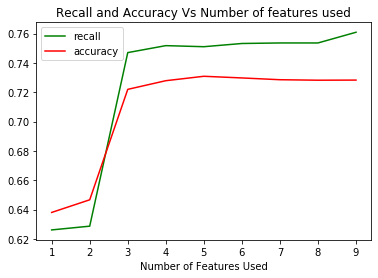

In [26]:
x = range(1,len(list_recall)+1)
plt.title('Recall and Accuracy Vs Number of features used')
plt.xlabel('Number of Features Used')
plt.plot(x,list_recall,color='green')
plt.plot(x,list_accuracy,color='red')
plt.legend(['recall','accuracy'])


***We decide to keep the best 5 fetaures***

## Final Model

In [27]:
n_features = 5
clf = RandomForestClassifier(n_estimators = 190,max_depth = 15)
X_train_f = X_train[sorted_features[:n_features]].copy()
X_test_f = X_test[sorted_features[:n_features]].copy()

clf.fit(X_train_f, y_train)
y_proba_pred = clf.predict_proba(X_test_f)
X_test_f['proba_churn'] = y_proba_pred[:,1]
X_test_f['real_churn'] = y_test

X_display = X_test_f[['proba_churn']]

**Preview of what the sales team could see and use**

In [28]:
X_display.sort_values(by='proba_churn',ascending = False)

,proba_churn
client_id,
1816902,0.987132
1284943,0.985604
681181,0.982318
1850997,0.977449
1888429,0.977353
...,...
256748,0.002610
1755244,0.002610
309820,0.002610


**The output of the model is a probability of Churn for every customers**

Sales Teams will be able to prioritize customers that are more likely to Churn (To be compared with other score metrics such as Loyalty, Monetary ...) 

# Third section: Evaluation metrics of the selected model

In [29]:
n_features = 11
clf = RandomForestClassifier(n_estimators = 190,max_depth = 15)
X_train_f = X_train[sorted_features[:n_features]].copy()
X_test_f = X_test[sorted_features[:n_features]].copy()

clf.fit(X_train_f, y_train)
y_proba_pred = clf.predict_proba(X_test_f)
X_test_f['proba_churn'] = y_proba_pred[:,1]
X_test_f['real_churn'] = y_test

In [30]:
X_test_f.head()

,slope_sales,Frequency,q9,std_delta_time,total_revenue,slope_delta_time,last_purchase,AOV,max_order,proba_churn,real_churn
client_id,,,,,,,,,,,
1380471,2.551035e-05,66,18.2,8.848430,46115.509107,0.129570,135.2400,698.719835,9004.398800,0.192569,1
2180554,1.992457e-02,11,104.2,43.662850,1075.245768,-0.007110,37.8350,97.749615,477.866400,0.531122,0
101746,-7.776552e-07,264,4.0,1.786739,239154.311266,-0.000007,390.9034,905.887543,23177.384543,0.090326,0
670193,1.281728e-04,13,13.8,12.187922,8594.409011,-0.555011,-722.0919,661.108385,7639.219624,0.866817,1
1249032,1.039114e-01,9,112.8,51.171979,6263.683533,0.753382,940.1112,695.964837,1416.225000,0.578858,0


[[0.72370286 0.27629714]
 [0.2471705  0.7528295 ]]


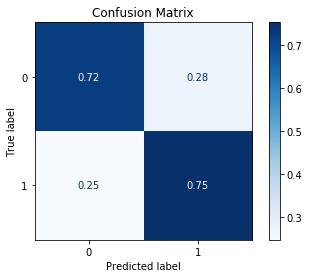

In [31]:
clf = RandomForestClassifier(max_depth = 15, n_estimators = 190)
clf.fit(X_train_f, y_train)
title = 'Confusion Matrix'
disp = plot_confusion_matrix(clf, X_test_f[X_train_f.columns], y_test,
                             cmap=plt.cm.Blues, normalize = 'true')
disp.ax_.set_title(title)

print(disp.confusion_matrix)

***We have a Recall of 77%.***
 We are able to spot 77% of potential churners

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.818


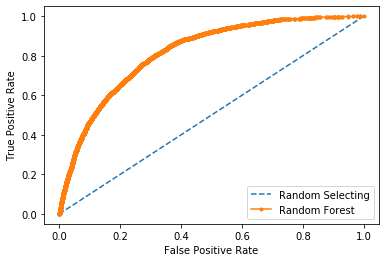

<Figure size 432x288 with 0 Axes>

In [34]:


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
testy = y_test
ns_probs = [0 for _ in range(len(testy))]

# keep probabilities for the positive outcome only
lr_probs = y_proba_pred[:,1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Selecting')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
plt.savefig('.courbe_AUC.pdf')

In [35]:
! ls

All models (Group 9).ipynb input_data
Group 9 (BCG).ipynb        input_data.zip


In [67]:
X_test_f['y'] = y_pred

In [46]:
df_fn = X_test_f.loc[(X_test_f.real_churn == 1) & (X_test_f.y == 0)]

In [47]:
df_tp = X_test_f.loc[(X_test_f.real_churn == 1) & (X_test_f.y == 1)]

In [82]:
df_fp_2 = X_test_f.loc[(X_test_f.real_churn == 0) & (X_test_f.proba_churn  >= 0.7)]

In [81]:
X_test_f

,slope_sales,Frequency,q9,std_delta_time,total_revenue,slope_delta_time,last_purchase,AOV,max_order,proba_churn,real_churn,y
client_id,,,,,,,,,,,,
1380471,2.551035e-05,66,18.2,8.848430,46115.509107,1.295697e-01,135.240000,698.719835,9004.398800,0.177326,1,0
2180554,1.992457e-02,11,104.2,43.662850,1075.245768,-7.109872e-03,37.835000,97.749615,477.866400,0.659033,0,1
101746,-7.776552e-07,264,4.0,1.786739,239154.311266,-6.824530e-06,390.903400,905.887543,23177.384543,0.056924,0,0
670193,1.281728e-04,13,13.8,12.187922,8594.409011,-5.550106e-01,-722.091900,661.108385,7639.219624,0.862223,1,1
1249032,1.039114e-01,9,112.8,51.171979,6263.683533,7.533818e-01,940.111200,695.964837,1416.225000,0.619638,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
708894,6.138806e-04,39,29.6,14.510211,13661.000241,6.906729e-02,201.204000,350.282057,2608.549600,0.124807,0,0
1067492,1.082817e-01,7,32.0,20.331421,1033.846412,3.715093e-05,349.600000,147.692345,1819.585200,0.813266,0,1
746733,9.689332e-03,15,45.3,20.166477,4762.529776,-1.888299e-05,232.037800,317.501985,1639.798800,0.573777,1,1


In [55]:
df_tp = pd.merge(df_tp,data_set[['avg_delta_time']],how='left',right_index=True,left_index=True)

In [56]:
df_tp

,slope_sales,Frequency,q9,std_delta_time,total_revenue,proba_churn,real_churn,y,avg_delta_time
client_id,,,,,,,,,
670193,0.000128,13,13.8,12.187922,8594.409011,0.743500,1,1,7.000000
1400013,0.022089,8,74.6,34.180195,4423.003469,0.656756,1,1,30.571429
1086481,0.010125,8,35.8,13.149326,3856.187360,0.935935,1,1,20.285714
2254881,0.165531,19,52.8,26.538479,17370.897186,0.746110,1,1,16.944444
1811044,0.584371,7,6.0,3.162278,1547.391879,0.568628,1,1,2.000000
...,...,...,...,...,...,...,...,...,...
1415755,0.000644,11,37.1,45.661679,2938.689607,0.560931,1,1,18.100000
505376,-0.000193,7,146.5,77.825446,1542.348628,0.743715,1,1,65.000000
784072,0.073021,24,18.0,41.246200,6216.984983,0.745108,1,1,15.608696


In [57]:
df_tp['missed_revenue'] = ((df_tp['total_revenue'] / df_tp['Frequency']) / df_tp['avg_delta_time']) * 365

In [64]:
(df_tp['missed_revenue'].sum()/(10**6))*(0.15)*15

160.94711931086312

In [74]:
df_tp = pd.merge(df_fp,data_post[['client_id','total_revenue']],how='left',left_index=True,right_on='client_id')

In [87]:
(((df_tp.total_revenue_y.sum()*(4/3))*15)/(10**6))*(0.05)

27.061620584620155

In [84]:
df_tp = df_tp.loc[df_tp.proba_churn >= 0.7]

In [85]:
df_tp

,slope_sales,Frequency,q9,std_delta_time,total_revenue_x,slope_delta_time,last_purchase,AOV,max_order,proba_churn,real_churn,y,client_id,total_revenue_y
81803,0.012579,11,30.6,21.792200,7756.100342,0.159919,312.094452,705.100031,1399.029188,0.798320,0,1,1427382,1234.775332
20590,0.000035,12,13.0,7.891307,4222.384121,-0.008614,283.540933,351.865343,1411.838455,0.785540,0,1,358210,735.601319
60368,0.140929,9,22.2,11.685614,1957.383671,0.002625,324.615928,217.487075,523.368527,0.919971,0,1,1054178,983.066981
3377,0.041964,7,96.5,50.755952,2022.162147,0.017114,126.932400,288.880307,1033.436000,0.719759,0,1,58088,691.311920
112838,0.000004,41,5.0,1.881080,31743.686256,0.066126,106.943560,774.236250,11286.104140,0.803335,0,1,1962184,59054.895341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6653,-0.000011,25,11.0,8.851021,44895.351885,0.850557,315.817600,1795.814075,20791.601333,0.705939,0,1,114443,73124.654091
19479,0.014345,7,82.5,40.495267,1660.639652,0.175720,155.388000,237.234236,554.299080,0.738372,0,1,338082,1428.958567
98607,0.000525,7,42.0,16.186414,1272.501496,0.255396,34.946016,181.785928,391.353280,0.808505,0,1,1719850,312.668440
35486,0.000536,14,21.8,14.818561,10466.533466,-0.050330,509.765100,747.609533,3116.426400,0.775059,0,1,619241,2319.099379
